# Collect the items - discrete actions

in order to be able to use rllib's DQN is necessary to implement a new version of the environment in which actions are discrete instead of continuous. 

Still the agents' goal is the same as before: collecting all the items in the environment minimizing the number of steps by collaborating together. 

## Preparing the notebook

### import and utils

In [7]:
from utils.vectors import Vector2D
from utils.canvas import CanvasWithBorders
from utils.algo_utils import (save_algo, load_algo, disable_exploration, enable_exploration, keep_best_policy_only, compute_performance)
from utils.metrics import (save_dict_as_json, load_json_as_dict, plot_metrics, compare_metrics)
from utils.simulations import (simulate_episode, simulate_random_episode, dqn_result_format, simulate_episode_multipolicy)
from utils.dictionary import mean_dict

from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiDiscrete
from gymnasium.spaces.utils import flatten, flatten_space
from IPython.display import (clear_output, display)
from ipycanvas import Canvas, hold_canvas
from typing import Set
import random as rnd
import numpy as np
import math

### defining the environment

In [4]:
class EnvironmentConfiguration: 
    def __init__(self, n_agents, n_items, agent_range, movement_sensitivity, speed_sensitivity, spawn_area=100, visible_nbrs=1, visible_items=1, max_steps=None, memory_size=1):
        # parameters that shouldn't affect the agents' behaviour
        self.n_agents = n_agents
        self.n_items = n_items
        self.spawn_area = spawn_area
        self.max_steps = max_steps
        # parameters that affect the agents' behavious
        self.agent_range = agent_range
        # parameters that affect the observation space
        self.visible_nbrs = visible_nbrs
        self.visible_items = visible_items
        self.memory_size = memory_size
        # parameters that affect the action space
        self.movement_sensitivity = movement_sensitivity
        self.speed_sensitivity = speed_sensitivity

    def __deepcopy__(self, memo):
        return EnvironmentConfiguration(
            self.n_agents, 
            self.n_items, 
            self.agent_range, 
            self.movement_sensitivity, 
            self.speed_sensitivity, 
            self.spawn_area, 
            self.visible_nbrs, 
            self.visible_items, 
            self.max_steps, 
            self.memory_size
        )

In [5]:
class CollectTheItems(MultiAgentEnv):
    canvas = None
    CANVAS_WIDTH, CANVAS_HEIGHT = 300.0, 300.0

    def __init__(self, config: EnvironmentConfiguration):
        assert config.n_agents > config.visible_nbrs
        assert config.movement_sensitivity % 2 == 1

        self.n_agents = config.n_agents
        self.n_items = config.n_items
        self.spawn_area = config.spawn_area
        self.max_steps = config.max_steps
        self.agent_range = config.agent_range
        self.visible_nbrs = config.visible_nbrs
        self.visible_items = config.visible_items
        self.memory_size = config.memory_size
        self.movement_sensitivity = config.movement_sensitivity
        self.speed_sensitivity = config.speed_sensitivity
        self.step_penalty = 1

        self.agents_ids = ['agent-' + str(i) for i in range(self.n_agents)]
        self.observation_space = self.observation_space('agent-0')
        self.action_space = self.action_space('agent-0')

    def unflatten_observation_space(self, agent):
        direction = Box(low=-1, high=1, shape=(2,1), dtype=np.float32)
        distance = Box(low=-np.inf, high=np.inf, shape=(1,1), dtype=np.float32)

        nbrs = Dict({f"nbr-{i}": Dict({'direction': direction, 'distance': distance}) for i in range(self.visible_nbrs)})
        items = Dict({f"item-{i}": Dict({'direction': direction, 'distance': distance}) for i in range(self.visible_items)})

        time_t_obs = Dict({"nbrs": nbrs, "items": items})

        return Dict({f"t[-{t}]": time_t_obs for t in range(0, self.memory_size)})

    def observation_space(self, agent):
        return flatten_space(self.unflatten_observation_space(agent))

    def __continuous_action(self, discrete_action):
        action_tuple = (discrete_action // (self.movement_sensitivity*self.speed_sensitivity), 
                        (discrete_action % (self.movement_sensitivity*self.speed_sensitivity)) // (self.speed_sensitivity), 
                        discrete_action % self.speed_sensitivity)

        return [(2*(action_tuple[0] / (self.movement_sensitivity-1))-1),
                (2*(action_tuple[1] / (self.movement_sensitivity-1))-1),
                (action_tuple[2]) / float(self.speed_sensitivity-1)]

    def action_space(self, agent):
        """
        direction_x = Discrete(self.movement_sensitivity)#Box(low=-1.0, high=1.0, shape=(2,1), dtype=np.float32)
        direction_y = Discrete(self.movement_sensitivity)
        speed = Discrete(self.speed_sensitivity)#Box(0.0, 1.0, dtype=np.float32)
        return Tuple([direction_x, direction_y, speed])
        """
        return Discrete(self.movement_sensitivity * self.movement_sensitivity * self.speed_sensitivity)
    
    def __get_time_t_observation(self, agent):
        nbrs_distance_vectors = [Vector2D.distance_vector(self.agents_pos[agent], self.agents_pos[nbr])  
                            for nbr in self.__get_n_closest_neighbours(agent, self.visible_nbrs)]

        items_distance_vectors = [Vector2D.distance_vector(self.agents_pos[agent], self.items_pos[item])  
                            for item in self.__get_n_closest_items(agent, self.visible_items)]

        nbrs = {
            f"nbr-{i}": {
                "direction": Vector2D.unit_vector(nbrs_distance_vectors[i]).to_np_array(),
                "distance": np.log(1 + Vector2D.norm(nbrs_distance_vectors[i])) #1 - np.exp(-alpha * x)
            }
            for i in range(len(nbrs_distance_vectors))
        }
    
        items = {
            f"item-{i}": {
                "direction": Vector2D.unit_vector(items_distance_vectors[i]).to_np_array(),
                "distance": np.log(1 + Vector2D.norm(items_distance_vectors[i])) #1 - np.exp(-alpha * x)
            }
            for i in range(len(items_distance_vectors))
        }
        
        for i in range(len(items_distance_vectors), self.visible_items):
            items[f"item-{i}"] = {
                "direction": np.array([0,0], dtype=np.int32),
                "distance": -1 #1 - np.exp(-alpha * x)
            }

        obs = {
            "nbrs": nbrs,
            "items": items
        }

        return obs

    def __get_observation(self, agent):
        if len(self.observation_cache[agent]) == 0:
            self.observation_cache[agent] = [self.__get_time_t_observation(agent)]*self.memory_size
        else:
            self.observation_cache[agent] = [self.__get_time_t_observation(agent)] + self.observation_cache[agent]
            self.observation_cache[agent].pop()

        obs = {
            f"t[-{t}]": self.observation_cache[agent][t]
            for t in range(0, self.memory_size)
        }

        return flatten(self.unflatten_observation_space(agent), obs)

    def rgb_to_hex(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'

    def __get_local_reward(self, agent, action):
        # reward_1: small bonus if the agent collects an item
        reward_1 = +5 if agent in self.collectors else 0

        # reward_2: malus if the agent collides with another agent 
        reward_2= sum([-2 if Vector2D.distance(self.agents_pos[agent], self.agents_pos[nbr]) < self.agent_range*2 else 0 for nbr in self.__get_other_agents(agent)])

        # reward_3: -1 at each step
        reward_3 = -self.step_penalty

        # reward_4: positive reward if the agent moves toward the closest items, negative otherwise
        distance_diff = ([Vector2D.distance(self.agent_old_pos[agent], self.items_pos[item]) -
                    Vector2D.distance(self.agents_pos[agent], self.items_pos[item])
            for item in self.closest_items[agent]])
        
        reward_4 = max(distance_diff) if len(distance_diff) > 0 else 0

        # reward_5: positive reward when increasing the distance from the neighbours
        distance_diff = [Vector2D.distance(self.agents_pos[agent], self.agents_pos[nbr]) -
                         Vector2D.distance(self.agent_old_pos[agent], self.agent_old_pos[nbr])
                         for nbr in self.__get_n_closest_neighbours(agent, self.visible_nbrs)]
        
        reward_5 = np.mean(distance_diff)/2.0 if len(distance_diff) > 0 else 0

        # reward_6: positive reward if an old visible item has been collected
        old_visible_item_collected = [1 if not(item in self.items_pos.keys()) else 0 for item in self.old_visible_items[agent]]
        self.old_visible_items[agent] = self.__get_n_closest_items(agent, self.visible_items)

        reward_6 = sum(old_visible_item_collected) * 100

        self.info[agent] = {"info": {f"r2: {reward_2}, r3: {reward_3}, r4: {reward_4} , r5: {reward_5}, r6: {reward_6}"}}
        return  reward_3 + reward_4*3 + reward_2 + reward_5 + reward_6

    def __get_global_reward(self):
        return 0#self.global_reward * 100
    
    def __get_other_agents(self, agent):
        return [other for other in self.agents_ids if other != agent]

    def __get_n_closest_neighbours(self, agent, n=1):
        distances = {other: Vector2D.distance(self.agents_pos[agent], self.agents_pos[other]) for other in self.__get_other_agents(agent)}
        return [neighbour[0] for neighbour in sorted(list(distances.items()), key=lambda d: d[1])[:n]]
        # return {neighbour[0]: neighbour[1] for neighbour in sorted(list(dst.items()), key=lambda d: d[0])[:n]}

    def __get_n_closest_items(self, agent, n=1):
        n = min(n, len(self.items_pos.keys()))
        distances = {item: Vector2D.distance(self.agents_pos[agent], pos) for item, pos in self.items_pos.items()}
        self.closest_items[agent] = [item[0] for item in sorted(list(distances.items()), key=lambda d: d[1])[:n]]
        return self.closest_items[agent]

    def __update_agent_position(self, agent, action):
        unit_movement = Vector2D(action[0], action[1])
        self.agent_old_pos[agent] = self.agents_pos[agent]
        self.agents_pos[agent] = Vector2D.sum(self.agents_pos[agent], Vector2D.mul(unit_movement, action[2]))

    def __collect_items(self):
        self.collectors = []
        uncollected_items = {}
        for item, item_pos in self.items_pos.items():
            collected = False
            for agent in self.agents_pos.values():
                if Vector2D.distance(item_pos, agent) < self.agent_range:
                    collected = True
                    self.collectors.append(agent)
            if not collected:
                uncollected_items[item] = item_pos
        self.items_pos = uncollected_items

    def increase_step_penalty(self, inc):
        self.step_penalty += inc       

    def __collect_items_and_compute_global_reward(self):
        old_uncollected_items = len(self.items_pos.keys())
        self.__collect_items()
        updated_uncollected_items = len(self.items_pos.keys())
        self.global_reward = old_uncollected_items - updated_uncollected_items

    def reset(self, seed=None, options=None):
        if seed is not None:
            rnd.seed(seed)
            np.random.seed(seed)

        self.steps = 0
        self.agents_pos = {agent: Vector2D.get_random_point(max_x=self.spawn_area, max_y=self.spawn_area) for agent in self.agents_ids}
        self.agent_old_pos = dict(self.agents_pos)
        self.items_pos = {f"item-{i}": Vector2D.get_random_point(max_x=self.spawn_area, max_y=self.spawn_area) for i in range(self.n_items)}
        self.collectors = []
        self.closest_items = {}
        self.old_visible_items = {agent: self.__get_n_closest_items(agent, self.visible_items) for agent in self.agents_ids}
        self.info = {}
        self.observation_cache = {agent: [] for agent in self.agents_ids}
        return {agent: self.__get_observation(agent) for agent in self.agents_ids}, {}
     
    def step(self, actions):
        self.steps += 1
        observations, rewards, terminated, truncated, infos = {}, {}, {}, {}, {}

        for agent, action in actions.items():
            self.__update_agent_position(agent, self.__continuous_action(action))

        self.__collect_items_and_compute_global_reward()

        for agent, action in actions.items():
            observations[agent] = self.__get_observation(agent)
            rewards[agent] = self.__get_local_reward(agent, self.__continuous_action(action)) + self.__get_global_reward()
            terminated[agent] = False
            truncated[agent] = False
            infos[agent] = self.info[agent]

        truncated['__all__'] = False
        if len(self.items_pos.keys()) == 0:
            terminated['__all__'] = True
        elif self.max_steps != None and self.steps == self.max_steps:
            terminated['__all__'] = True
        else:
            terminated['__all__'] = False
        
        if terminated['__all__'] == True:
            for key in terminated.keys():
                terminated[key] = True

        return observations, rewards, terminated, truncated, infos
     
    def rgb_to_hex(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'

    def render(self):
        pass

    def get_agent_ids(self):
       return self.agents


class RenderableCollectTheItems(CollectTheItems):
    def __init__(self, config: EnvironmentConfiguration):
        super().__init__(config)
        self.agent_colors = {agent: self.rgb_to_hex(rnd.randint(0, 255), rnd.randint(0, 255), rnd.randint(0, 255)) for agent in self.agents_ids}

        self.unit = self.CANVAS_WIDTH/float(self.spawn_area)
        self.render_size_agent = max(self.unit,1)
        self.render_size_agent_range = self.unit*self.agent_range

        self.reset()

    def __position_in_frame(self, position_in_env):
        return [((self.spawn_area-position_in_env[0])/self.spawn_area)*self.CANVAS_WIDTH,
                        ((self.spawn_area-position_in_env[1])/self.spawn_area)*self.CANVAS_HEIGHT,]

    def render(self):
        with hold_canvas():
            if self.canvas == None:
                self.canvas = CanvasWithBorders(width=self.CANVAS_WIDTH, height=self.CANVAS_HEIGHT)
                display(self.canvas)

            self.canvas.clear()

            self.canvas.fill_style = "red"
            for item in self.items_pos.values():
                self.canvas.draw_circle(pos=self.__position_in_frame(item.to_np_array()), 
                                        radius=2, 
                                        fill_color="red")

            for agent in self.agents_ids:
                self.canvas.draw_circle(pos=self.__position_in_frame(self.agents_pos[agent].to_np_array()), 
                                        radius=self.render_size_agent/2.0, 
                                        fill_color=self.agent_colors[agent],
                                        border_color="black")

                self.canvas.draw_circle(pos=self.__position_in_frame(self.agents_pos[agent].to_np_array()), 
                                        radius=self.render_size_agent_range, 
                                        border_color="red")

### environment demonstration

In [6]:
env_config = EnvironmentConfiguration(
    n_agents = 4,
    n_items = 10,
    spawn_area = 100,
    max_steps=300,
    agent_range = 5,
    visible_nbrs = 3,
    visible_items = 3,
    memory_size=3,
    movement_sensitivity=5,
    speed_sensitivity=5
)

env = RenderableCollectTheItems(env_config)

print("action space: ", env.action_space)
print("observation space: ", env.unflatten_observation_space("agent-0"))
simulate_random_episode(env, 100, sleep_between_frames=0.01, print_info=False)

action space:  Discrete(125)
observation space:  Dict('t[-0]': Dict('items': Dict('item-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'item-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'item-2': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32))), 'nbrs': Dict('nbr-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-2': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)))), 't[-1]': Dict('items': Dict('item-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'item-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'item-2': Dict('direc

CanvasWithBorders(height=300, width=300)

## Training

### preparing the environment

In [ ]:
from ray.tune.registry import register_env

n_agents = 4
env_config = EnvironmentConfiguration(
    n_agents = n_agents,
    n_items = 10,
    spawn_area = 200,
    max_steps=300,
    agent_range = 3,
    visible_nbrs = 3,
    visible_items = 3,
    memory_size=3,
    movement_sensitivity=5,
    speed_sensitivity=5)

register_env("collect_the_items?algo=DQN&method=CTDE", lambda _: RenderableCollectTheItems(env_config))

env = CollectTheItems(env_config)

### restart ray

In [12]:
import ray
ray.shutdown()

### DQN DCDE [01] - no experience sharing

Each agent has its own policy and does not share any kind of information with the other agents

Use this strategy as *benchmark* for the following ones. 

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks

training_iterations = 50
policies = {f"agent-{i}": (None, None, None, {}) for i in range(n_agents)}

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            item_network_update_freq=500,
            double_q=True,
            dueling=True)
        .debugging(seed=3010)
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agentId, *args, **kwargs: agentId),
        )
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    simulate_episode_multipolicy(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=True)

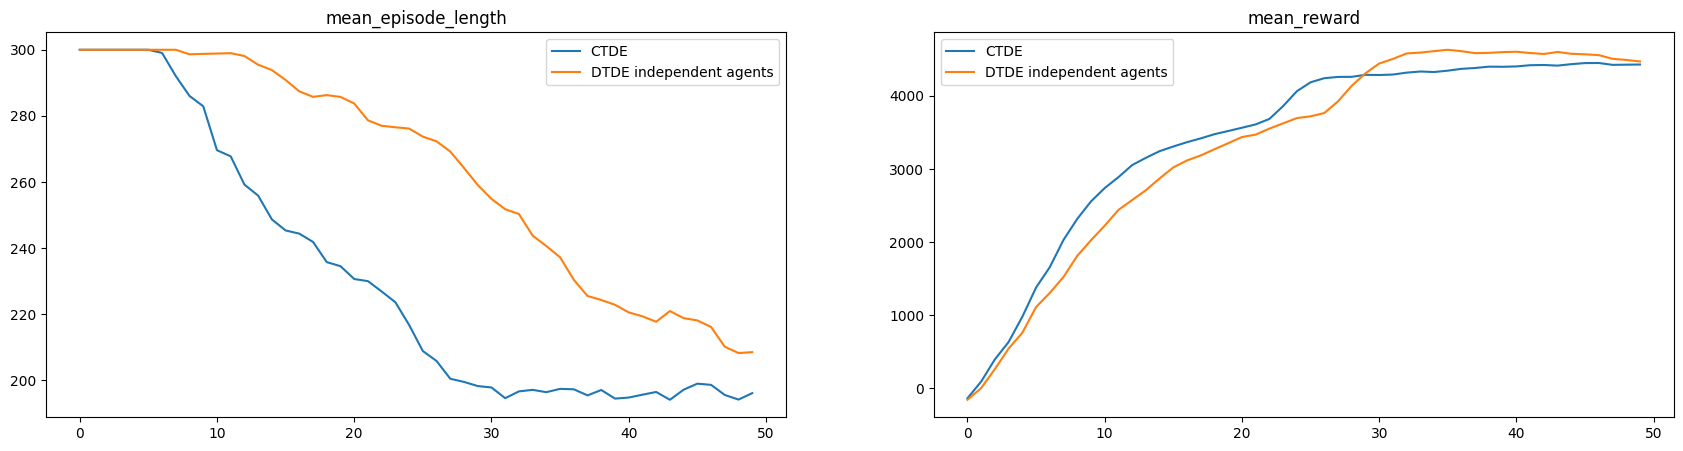

In [24]:
compare_metrics({
    "CTDE": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v4"),
    "DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),}, 
                "mean_episode_length", "mean_reward")

### DQN DCDE [02] - NN averaging

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks

n_fixed_nbrs = 3

def get_nbrs(agent, n_neighbours):
    agent_id = int(agent.split("-")[1])
    return [f"agent-{(agent_id+i)%n_agents}" for i in range(1, n_neighbours+1)]
    
class AveragePolicyCallback(DefaultCallbacks):

    def on_train_result(self, *, algorithm, result: dict, **kwargs):
        local_worker = algorithm.workers.local_worker()
        policies = local_worker.policy_map 
    
        new_policies = {}
        for agent in policies.keys():
            new_policies[agent] = mean_dict([policies[agent].get_weights() for agent in (get_nbrs(agent, n_fixed_nbrs) + [agent])]) 
    
        for agent in policies.keys():
            policies[agent].set_weights(new_policies[agent])
    
        algorithm.workers.sync_weights()


training_iterations = 50

policies = {f"agent-{i}": (None, None, None, {}) for i in range(n_agents)}

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            item_network_update_freq=500,
            double_q=True,
            dueling=True)
        .debugging(seed=3010)
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agentId, *args, **kwargs: agentId),
        )
        .callbacks(AveragePolicyCallback)
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    simulate_episode_multipolicy(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=False)
    #if i != 0 and i % 5 == 0:
    #    algo.workers.foreach_worker(lambda ev: ev.foreach_env(lambda env: env.increase_step_penalty(0.3)))

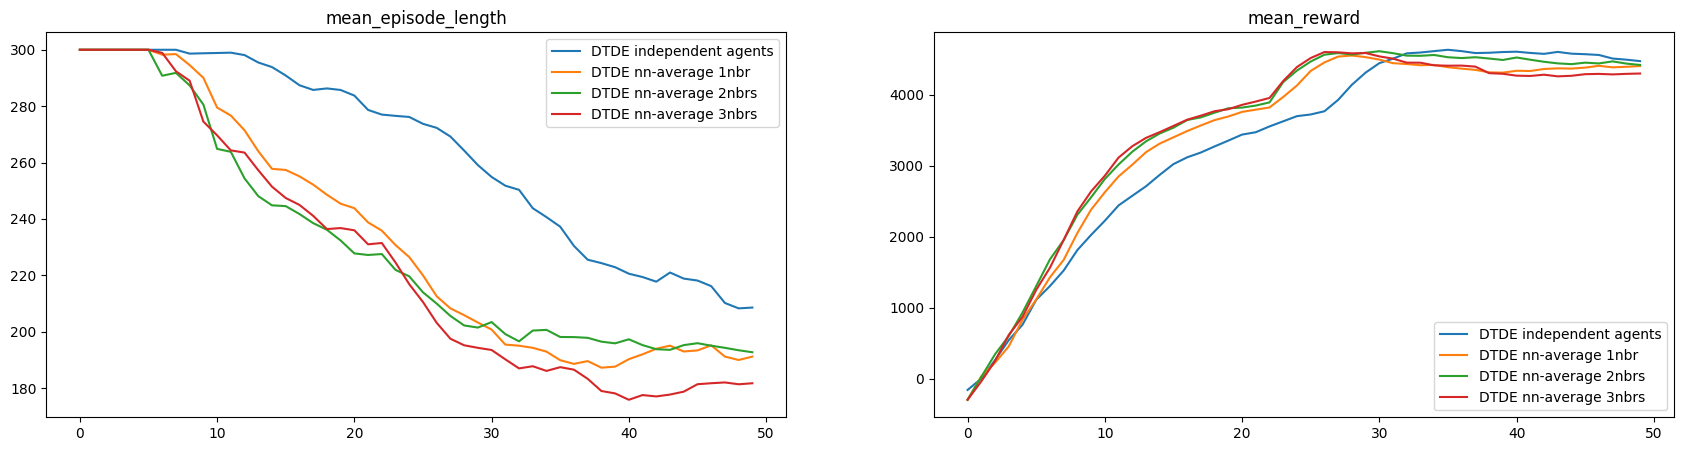

In [10]:
compare_metrics({"DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-average 1nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v0"),
                "DTDE nn-average 2nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v1"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2"),}, 
                "mean_episode_length", "mean_reward")

### DQN DCDE [03] - NN consensus

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
import copy

n_fixed_nbrs = 1

def get_nbrs(agent, n_neighbours):
    agent_id = int(agent.split("-")[1])
    return [f"agent-{(agent_id+i)%n_agents}" for i in range(1, n_neighbours+1)]
    
class SyncPolicyCallback(DefaultCallbacks):
    def on_train_result(self, *, algorithm, result: dict, **kwargs):
        local_worker = algorithm.workers.local_worker()
        policies = local_worker.policy_map 

        mean_episode_reward = result["sampler_results"]["policy_reward_mean"]

        new_policies = {}
        for agent in policies.keys():
            best_policy_in_nn = agent
            for nbr in get_nbrs(agent, n_fixed_nbrs):
                if mean_episode_reward[nbr] < mean_episode_reward[best_policy_in_nn]:
                    best_policy_in_nn = agent
            new_policies[agent] = copy.deepcopy(
                policies[best_policy_in_nn].get_weights())        
            
        for agent in policies.keys():
            policies[agent].set_weights(new_policies[agent])

        algorithm.workers.sync_weights()

training_iterations = 35

policies = {f"agent-{i}": (None, None, None, {}) for i in range(n_agents)}

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            item_network_update_freq=500,
            double_q=True,
            dueling=True,
            replay_buffer_config={"type": "MultiAgentPrioritizedReplayBuffer"})
        .debugging(seed=3010)
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agentId, *args, **kwargs: agentId),
        )
        .callbacks(SyncPolicyCallback)
        #.env_runners(num_env_runners=1)
        #.resources(num_gpus=0)
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    disable_exploration(algo)
    simulate_episode_multipolicy(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=False)
    enable_exploration(algo)

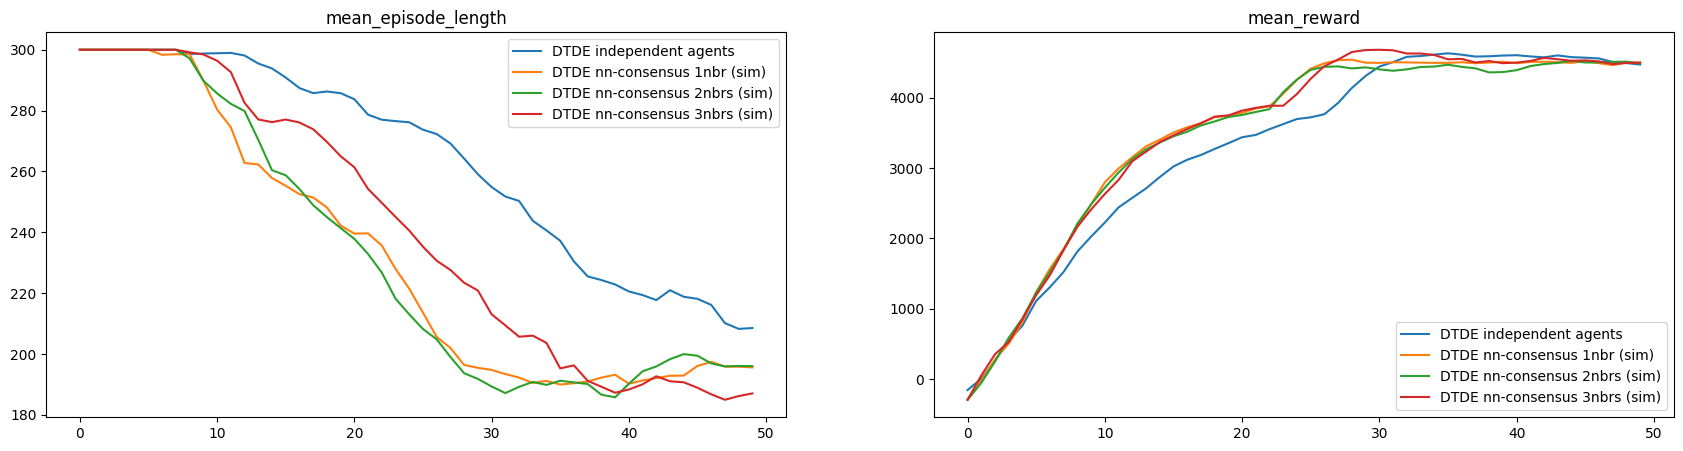

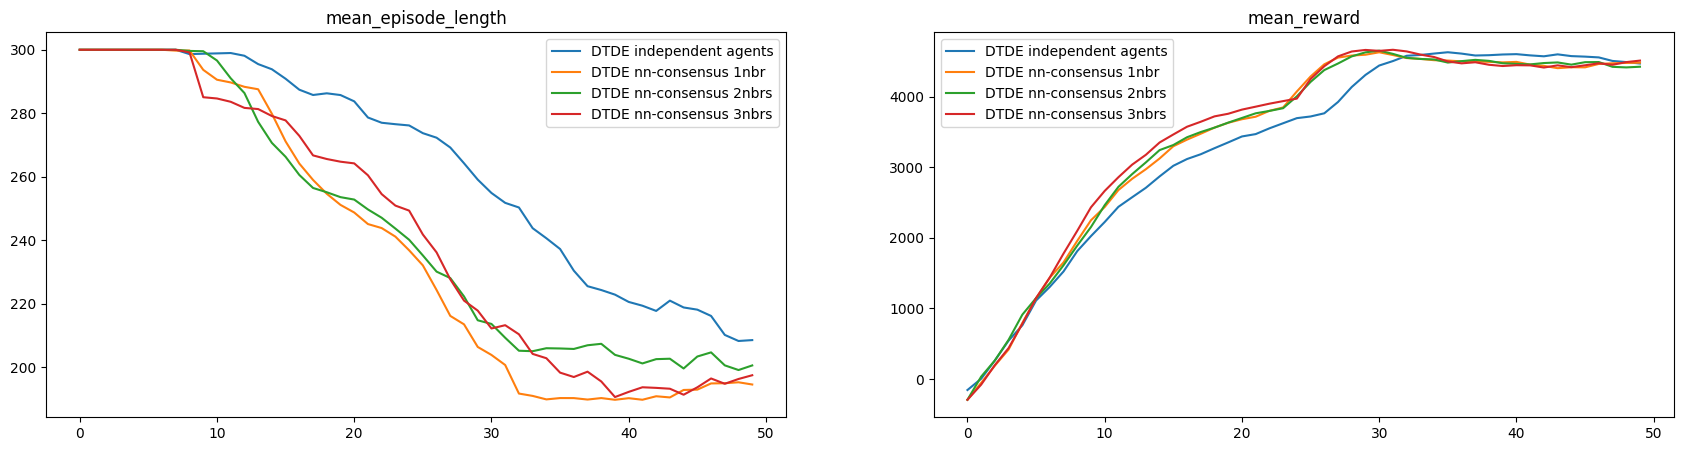

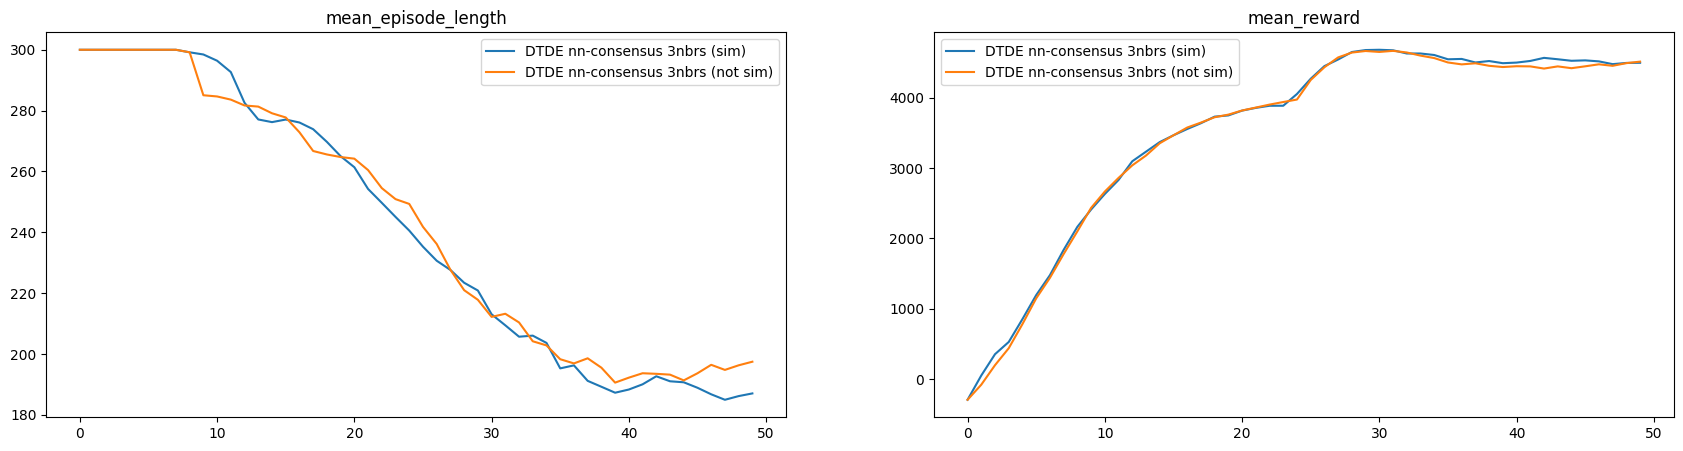

In [14]:

compare_metrics({"DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-consensus 1nbr (sim)": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v0A"),
                "DTDE nn-consensus 2nbrs (sim)": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v1A"),
                "DTDE nn-consensus 3nbrs (sim)": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2A"),}, 
                "mean_episode_length", "mean_reward")

compare_metrics({"DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-consensus 1nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v0B"),
                "DTDE nn-consensus 2nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v1B"),
                "DTDE nn-consensus 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2B"),}, 
                "mean_episode_length", "mean_reward")

compare_metrics({"DTDE nn-consensus 3nbrs (sim)": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2A"),
                "DTDE nn-consensus 3nbrs (not sim)": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2B")}, 
                "mean_episode_length", "mean_reward")


### DQN DCDE [04] - NN weighted averaging

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks

n_fixed_nbrs = 3

def get_nbrs(agent, n_neighbours):
    agent_id = int(agent.split("-")[1])
    return [f"agent-{(agent_id+i)%n_agents}" for i in range(1, n_neighbours+1)]
    
class AveragePolicyCallback(DefaultCallbacks):
    def on_train_result(self, *, algorithm, result: dict, **kwargs):
        local_worker = algorithm.workers.local_worker()
        policies = local_worker.policy_map 

        performance = result["sampler_results"]["policy_reward_mean"]
        
        print("Updating policies...")
        new_policies = {}
        for agent in policies.keys():
            weights = [performance[agent] for agent in (get_nbrs(agent, n_fixed_nbrs) + [agent])] 
            new_policies[agent] = mean_dict(
                [policies[agent].get_weights() for agent in (get_nbrs(agent, n_fixed_nbrs) + [agent])],
                weights/sum(weights))

        for agent in policies.keys():
            policies[agent].set_weights(new_policies[agent])

        algorithm.workers.sync_weights()


training_iterations = 50

policies = {f"agent-{i}": (None, None, None, {}) for i in range(n_agents)}

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            item_network_update_freq=500,
            double_q=True,
            dueling=True)
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agentId, *args, **kwargs: agentId),
        )
        .debugging(seed=3010)
        .callbacks(AveragePolicyCallback)
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    simulate_episode_multipolicy(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=False)

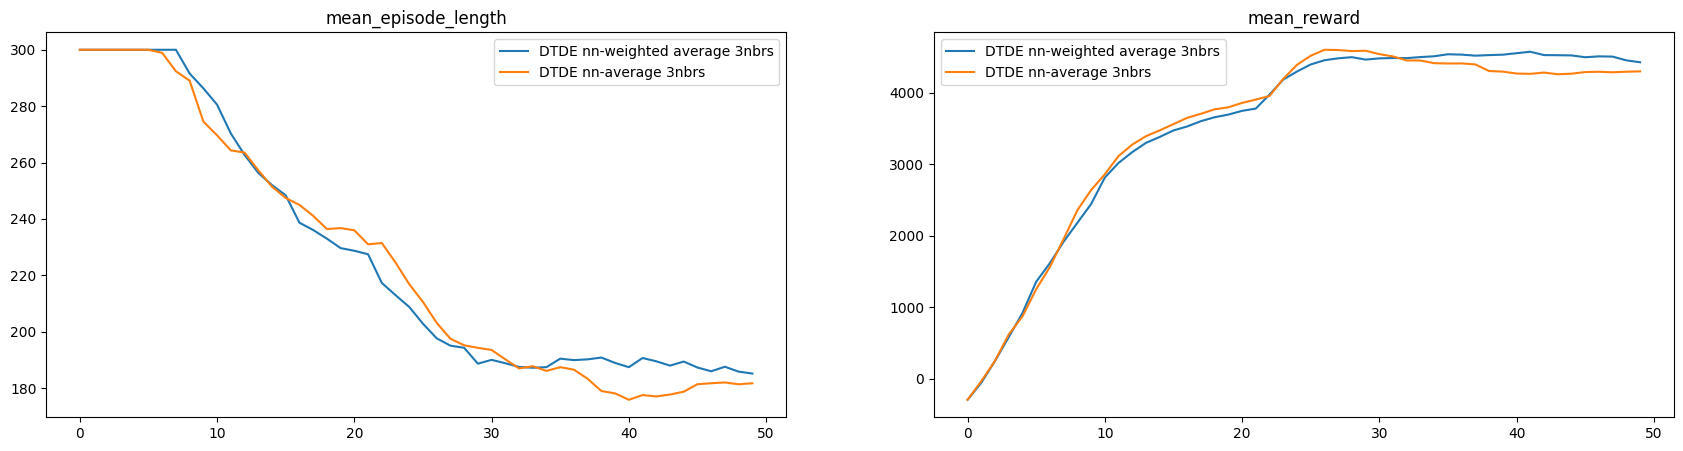

In [11]:
compare_metrics({"DTDE nn-weighted average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v2"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2"),}, 
                "mean_episode_length", "mean_reward")

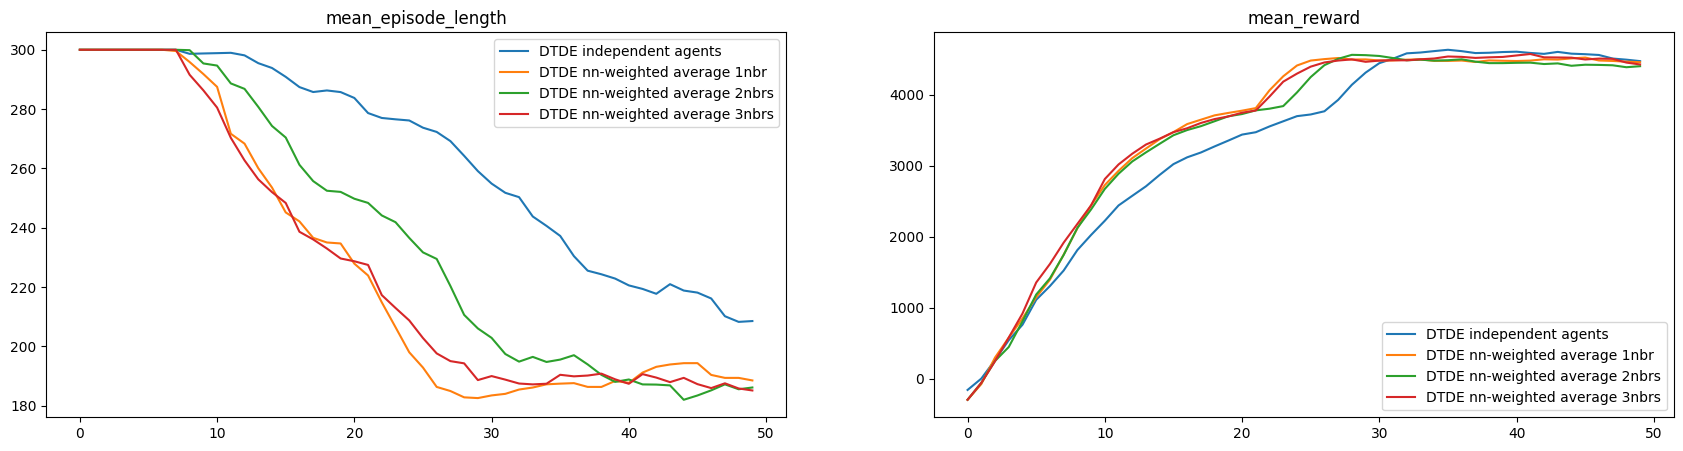

In [31]:
compare_metrics({"DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-weighted average 1nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v0"),
                "DTDE nn-weighted average 2nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v1"),
                "DTDE nn-weighted average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v2"),}, 
                "mean_episode_length", "mean_reward")

### DQN DCDE [05] - experience sharing

In [ ]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks

n_fixed_nbrs = 1

def get_nbrs(agent, n_neighbours):
    agent_id = int(agent.split("-")[1])
    return [f"agent-{(agent_id+i)%n_agents}" for i in range(1, n_neighbours+1)]
    
trajectory = None

class ExperienceSharing(DefaultCallbacks):

    def on_sample_end(self, *, samples):
        global trajectory
        if trajectory is None:
            trajectory = {agent: samples[agent] for agent in samples.policy_batches.keys()}
        else:
            for agent in samples.policy_batches.keys():
                trajectory[agent] = trajectory[agent].concat(samples[agent])

    def on_episode_end(self, *, worker, base_env, policies, episode, env_index):
        global algo, trajectory
        for agent in policies.keys():
            nbrs = get_nbrs(agent, n_fixed_nbrs)
            for nbr in nbrs:
                algo.local_replay_buffer._add_to_underlying_buffer(
                    agent, trajectory[nbr])
        trajectory = None
    
training_iterations = 50

policies = {f"agent-{i}": (None, None, None, {}) for i in range(n_agents)}

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            item_network_update_freq=500,
            double_q=True,
            dueling=True,
            replay_buffer_config={"type": "MultiAgentPrioritizedReplayBuffer"})
        .multi_agent(
            policies=policies,
            policy_mapping_fn=(lambda agentId, *args, **kwargs: agentId),
        )
        .callbacks(ExperienceSharing)
        .debugging(seed=3010)
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    simulate_episode_multipolicy(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=False)

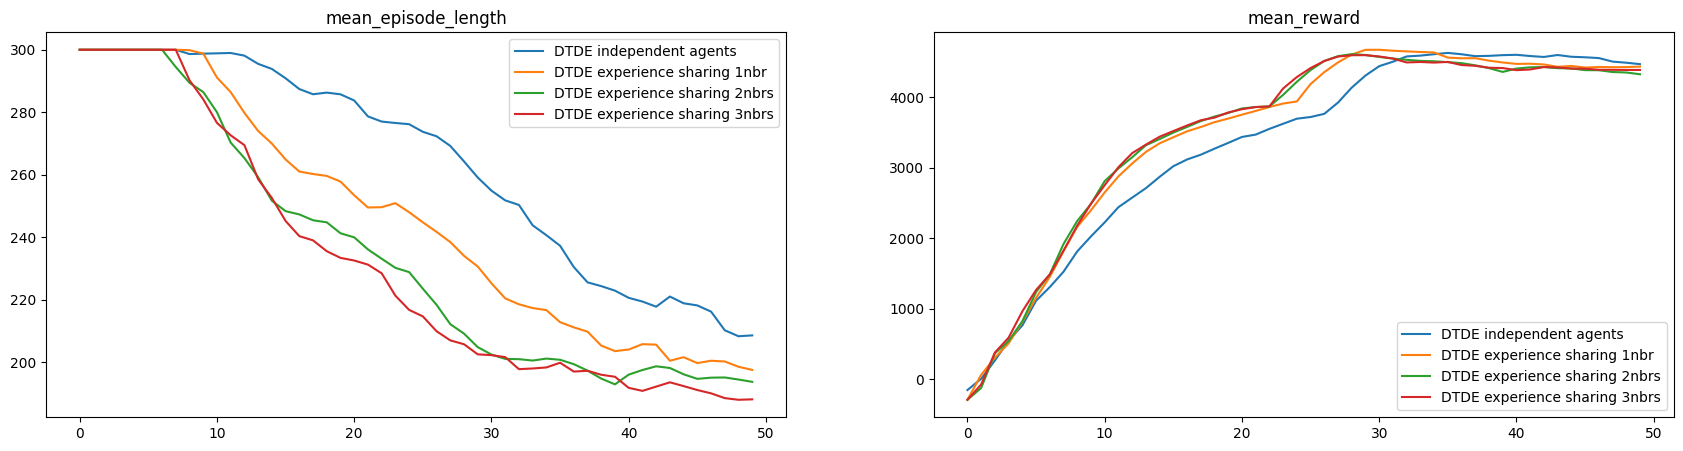

In [28]:
compare_metrics({"DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE experience sharing 1nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v0"),
                "DTDE experience sharing 2nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v1"),
                "DTDE experience sharing 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2"),}, 
                "mean_episode_length", "mean_reward")

## Save and load

In [48]:
algo_name = "collect_the_items-algo=DQN&method=DTDE[05]_v2_2908"

In [ ]:
#keep_best_policy_only(algo, env)
save_algo(algo, algo_name)

In [49]:
save_dict_as_json(metrics, f"metrics/{algo_name}")

In [ ]:
algo = load_algo(algo_name)

In [ ]:
metrics = load_json_as_dict(f"metrics/{algo_name}")

## Results comparison

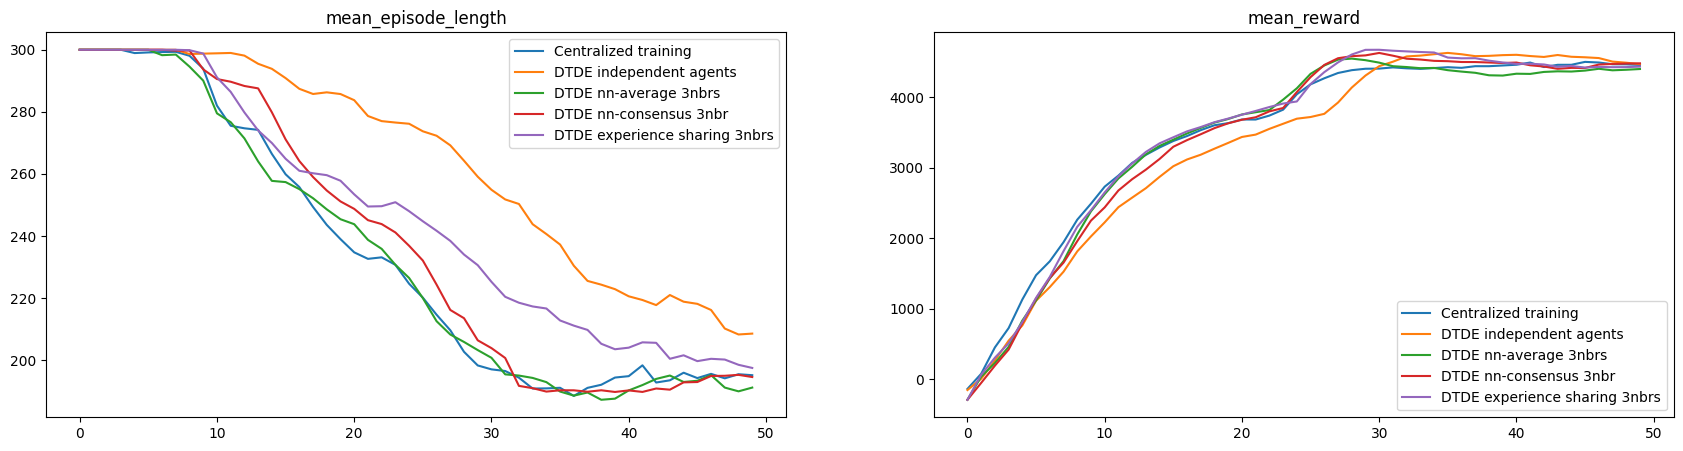

In [15]:
compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3"),
                "DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v0"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v0B"),
                "DTDE experience sharing 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v0"),}, 
                "mean_episode_length", "mean_reward")

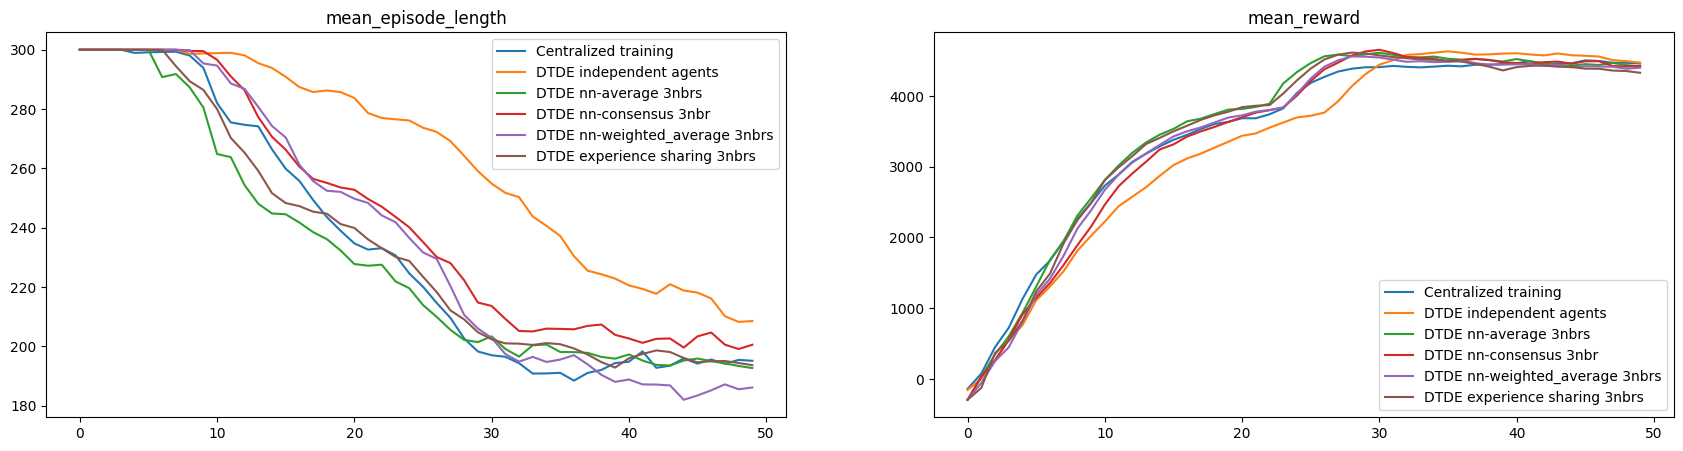

In [7]:
compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3"),
                "DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v1"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v1B"),
                "DTDE nn-weighted_average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v1"),
                "DTDE experience sharing 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v1"),}, 
                "mean_episode_length", "mean_reward")

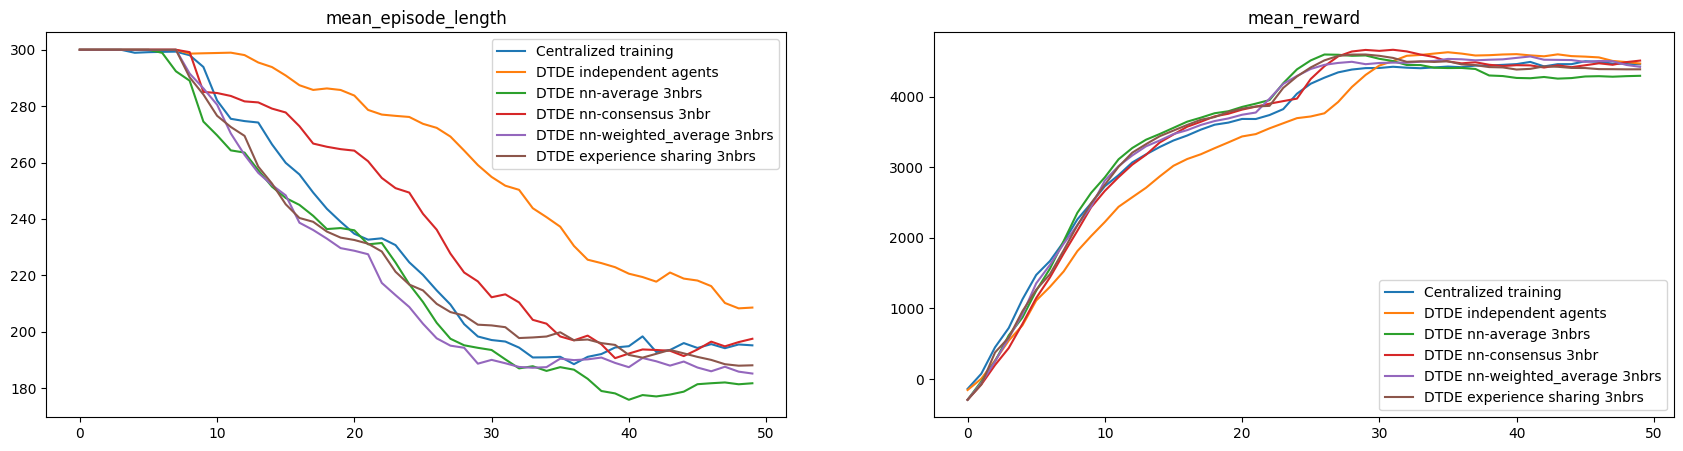

In [7]:
compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3"),
                "DTDE independent agents": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[01]_v0"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2B"),
                "DTDE nn-weighted_average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[04]_v2"),
                "DTDE experience sharing 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2"),}, 
                "mean_episode_length", "mean_reward")

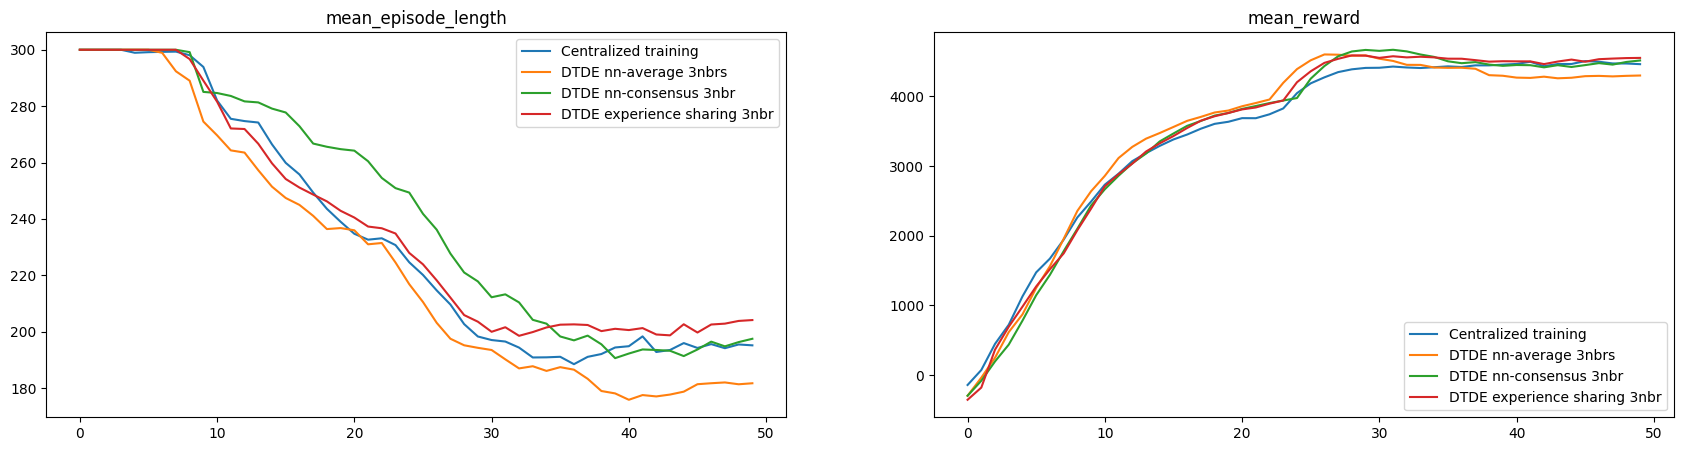

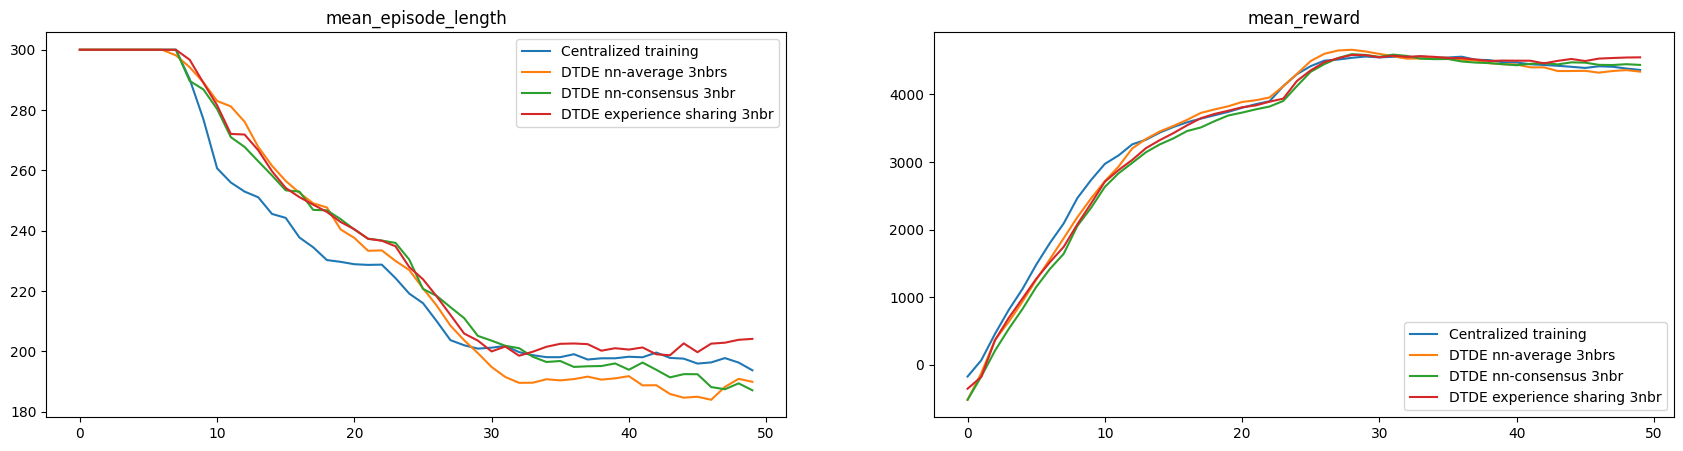

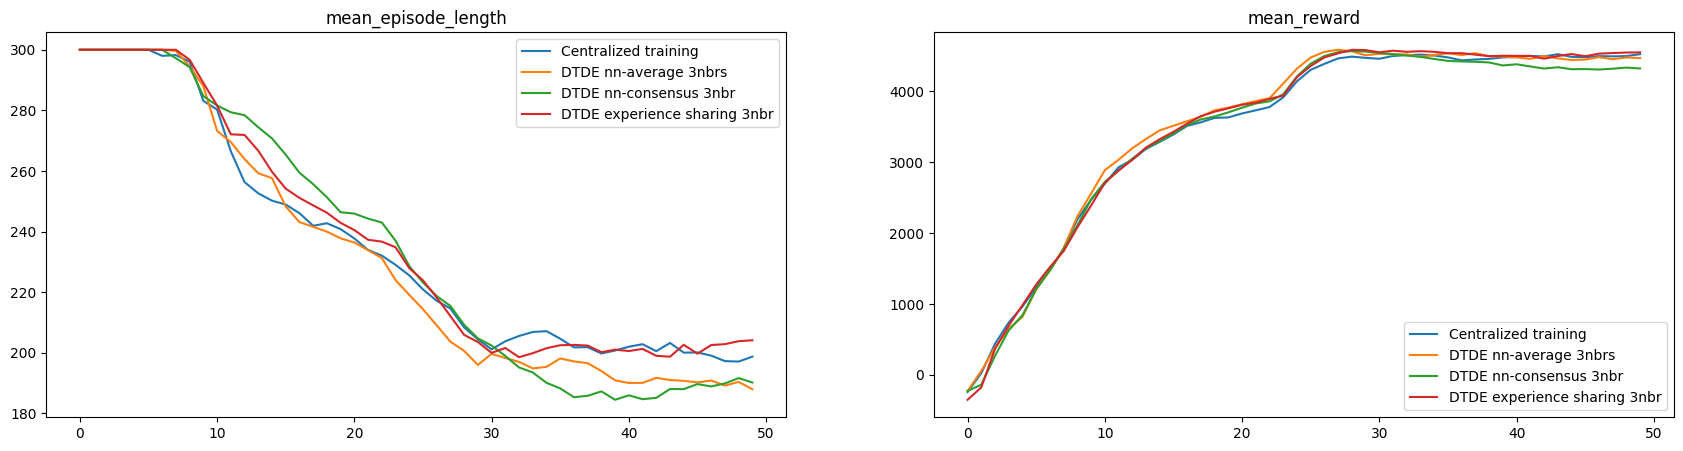

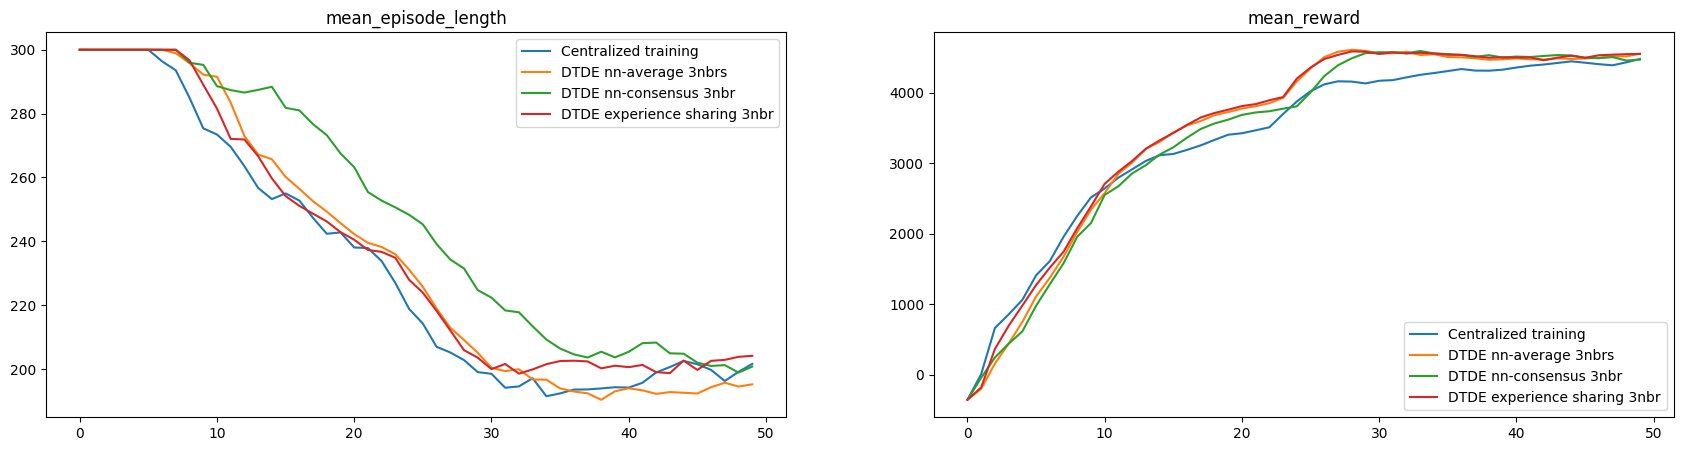

In [46]:
compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2B"),
                "DTDE experience sharing 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_911")}, 
                "mean_episode_length", "mean_reward")

compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_2908"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908"),
                "DTDE experience sharing 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_911")}, 
                "mean_episode_length", "mean_reward")

compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_2312"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_2312"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_2312"),
                "DTDE experience sharing 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_911")}, 
                "mean_episode_length", "mean_reward")

compare_metrics({"Centralized training": load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_911"),
                "DTDE nn-average 3nbrs": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_911"),
                "DTDE nn-consensus 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_911"),
                "DTDE experience sharing 3nbr": load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_911")}, 
                "mean_episode_length", "mean_reward")

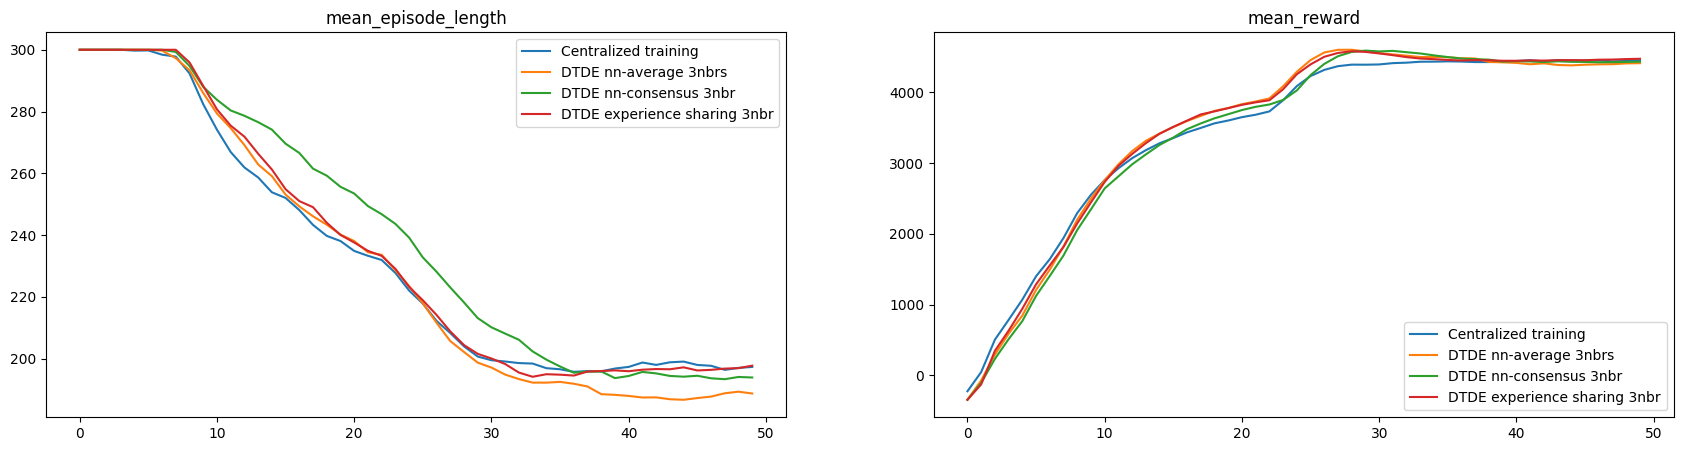

In [14]:
compare_metrics({"Centralized training": mean_dict([load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3"), load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_2908"), load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_2312"), load_json_as_dict("../CTDE/metrics/collect_the_items-algo=DQN&method=CTDE_v3_911")]),
                "DTDE nn-average 3nbrs": mean_dict([load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_2312"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[02]_v2_911")]),
                "DTDE nn-consensus 3nbr": mean_dict([load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2B"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_2312"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[03]_v2_911")]),
                "DTDE experience sharing 3nbr": mean_dict([load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_2312"), load_json_as_dict("metrics/collect_the_items-algo=DQN&method=DTDE[05]_v2_911")])}, 
                "mean_episode_length", "mean_reward")

## Simulation

In [15]:
new_config = env_config.__deepcopy__(None)
new_config.spawn_area = 50
new_config.n_items = 10
testing_env = RenderableCollectTheItems(new_config)
#simulate_episode(testing_env, algo, steps=300, sleep_between_frames=0.01)
simulate_episode_multipolicy(testing_env, algo, steps=30, sleep_between_frames=0.01, seed=2908)

# Comparison

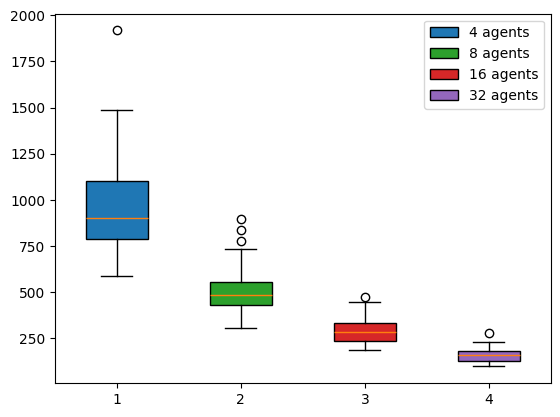

In [34]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="4 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="8 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="16 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="32 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()

## 4 agents

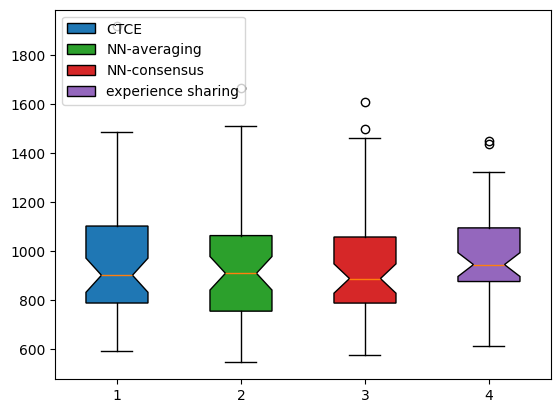

In [98]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           notch=True,
           label="CTCE",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[2],
           notch=True,
           label="NN-averaging",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[3],
           notch=True,
           label="NN-consensus",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[4],
           notch=True,
           label="experience sharing",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)
"""
ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=4&items=30&spawn_area=500"),
           positions=[5],
           notch=True,
           label="independent learners",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C5"},)
"""
ax.legend(loc='upper left')
plt.show()
print()

## 8 agents

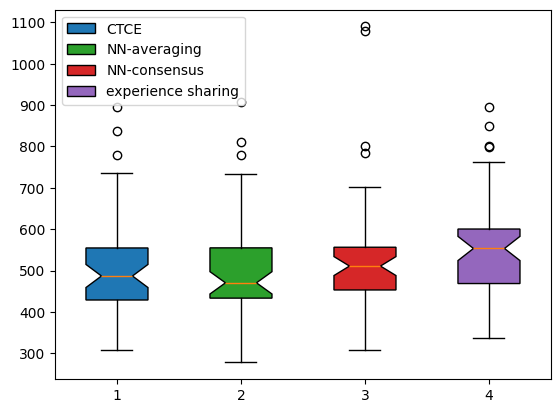

In [93]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=8&items=30&spawn_area=500"),
           positions=[1],
           notch=True,
           label="CTCE",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           notch=True,
           label="NN-averaging",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[3],
           notch=True,
           label="NN-consensus",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[4],
           notch=True,
           label="experience sharing",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)
"""
ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=8&items=30&spawn_area=500"),
           positions=[5],
           notch=True,
           label="independent learners",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C5"},)
"""
ax.legend()
plt.show()
print()

## 16 agents

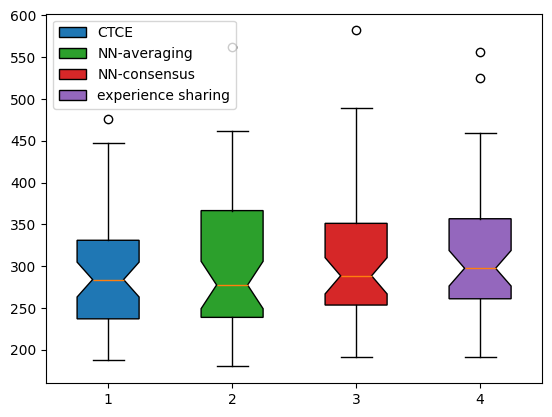

In [94]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=16&items=30&spawn_area=500"),
           positions=[1],
           notch=True,
           label="CTCE",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[2],
           notch=True,
           label="NN-averaging",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           notch=True,
           label="NN-consensus",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[4],
           notch=True,
           label="experience sharing",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)
"""
ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=16&items=30&spawn_area=500"),
           positions=[5],
           notch=True,
           label="independent learners",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C5"},)
"""
ax.legend()
plt.show()
print()

## 32 agents

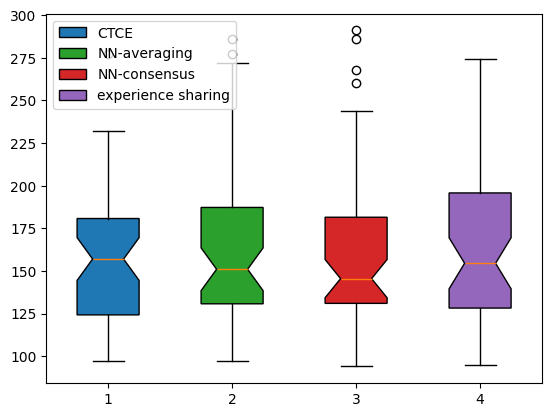

In [97]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=32&items=30&spawn_area=500"),
           positions=[1],
           notch=True,
           label="CTCE",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[2],
           notch=True,
           label="NN-averaging",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[3],
           notch=True,
           label="NN-consensus",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           notch=True,
           label="experience sharing",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)
"""
ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=32&items=30&spawn_area=500"),
           positions=[5],
           notch=True,
           label="independent learners",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C5"},)
"""
ax.legend(loc='upper left')
plt.show()
print()

## centralized

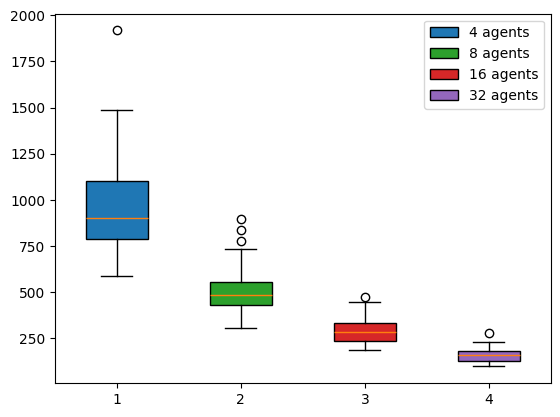

In [87]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="4 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="8 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="16 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=CTDE_v3_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="32 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()

## NN-averaging

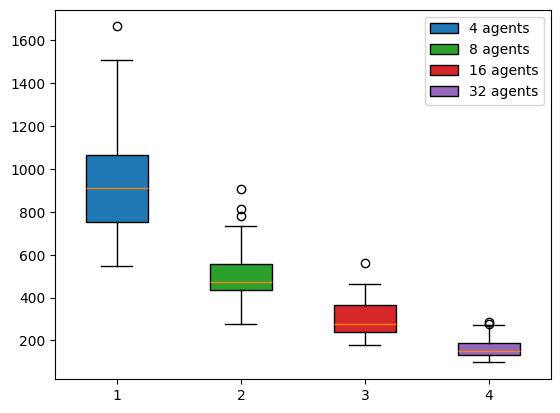

In [88]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="4 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="8 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="16 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[02]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="32 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()

## NN-consensus

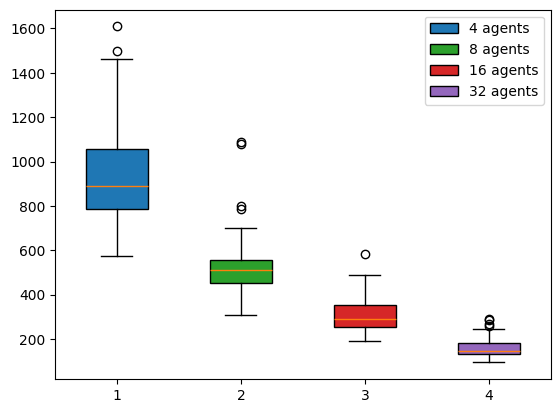

In [3]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="4 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="8 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="16 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[03]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="32 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()

## experience sharing

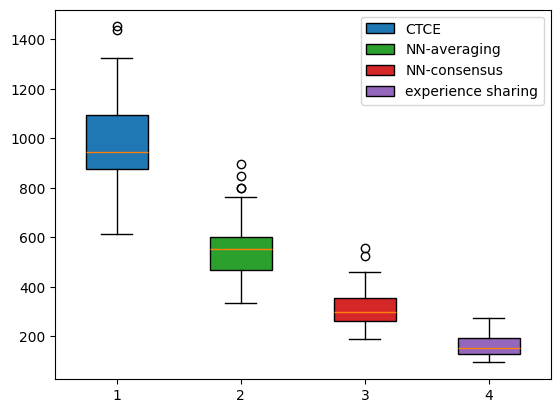

In [84]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="CTCE",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="NN-averaging",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="NN-consensus",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[05]_v2_2908--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="experience sharing",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()

## independent learners

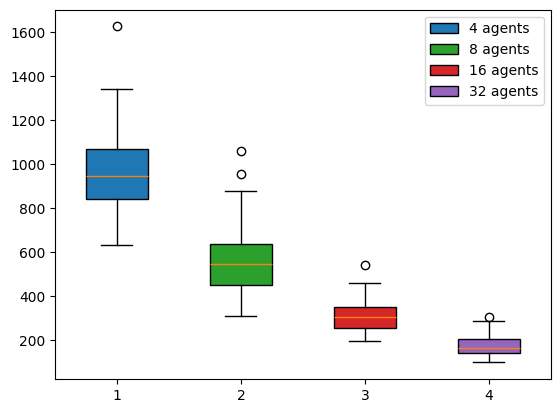

In [91]:
import json
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=4&items=30&spawn_area=500"),
           positions=[1],
           label="4 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C0"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=8&items=30&spawn_area=500"),
           positions=[2],
           label="8 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C2"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=16&items=30&spawn_area=500"),
           positions=[3],
           label="16 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C3"},)

ax.boxplot(load_json_as_dict("evaluation/collect_the_items-algo=DQN&method=DTDE[01]_v0--agents=32&items=30&spawn_area=500"),
           positions=[4],
           label="32 agents",
           widths=0.5,
           patch_artist=True, boxprops={"facecolor": "C4"},)

ax.legend()
plt.show()
print()